In [25]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

# basic tools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification

# classifiers from sklearns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
# from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score 

In [26]:
PATH = '/home/disk/orca/adaley17/MLGEO2024_TC_Tracks_Intensity/data/'
bt_data = 'clean/cleaned_best_track_data.csv'
ships_data = 'ai_ready/ai_ready_SHIPS_data.csv'

df_SHIPS = pd.read_csv(os.path.join(PATH, ships_data))
df_BT = pd.read_csv(os.path.join(PATH, bt_data))

In [27]:
df_SHIPS


,Original_Times,Code,Times,Daily_SST_Avg,Mid_Level_RH,Vert_Vel,Vshear,MSLP,Vmax,Latitude,Longitude
0,1982-06-02 12:00:00,AL011982,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1982-06-02 12:00:00,AL011982,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1982-06-02 12:00:00,AL011982,0.0,27.1,57.0,6.631183,15.227542,1005.0,10.28888,21.7,87.1
3,1982-06-02 12:00:00,AL011982,6.0,27.8,53.0,3.966363,15.536209,1004.0,12.86110,22.2,86.5
4,1982-06-02 12:00:00,AL011982,12.0,27.9,56.0,4.403641,15.330431,1003.0,15.43332,22.6,85.8
...,...,...,...,...,...,...,...,...,...,...,...
318545,2022-11-11 12:00:00,AL172022,96.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318546,2022-11-11 12:00:00,AL172022,102.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318547,2022-11-11 12:00:00,AL172022,108.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
318548,2022-11-11 12:00:00,AL172022,114.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
df_BT.head()

,ISO_TIME,USA_ATCF_ID,NAME,DIST2LAND,LANDFALL,STORM_SPEED,STORM_DIR,USA_LAT,USA_LON,USA_WIND,WMO_WIND,WMO_PRES,USA_PRES,USA_RMW,USA_WSPD
0,1982-06-02 12:00:00,AL011982,ALBERTO,22,40744.0,3.601108,47,21.7000,-87.1000,10.288880,10.28888,1005,1005.0,NaN,10.288880
1,1982-06-02 15:00:00,AL011982,ALBERTO,59,109268.0,4.115552,48,21.9551,-86.8077,11.317768,NaN,,1004.0,NaN,11.317768
2,1982-06-02 18:00:00,AL011982,ALBERTO,93,172236.0,4.115552,52,22.2000,-86.5000,12.861100,12.86110,1004,1004.0,NaN,12.861100
3,1982-06-02 21:00:00,AL011982,ALBERTO,130,209276.0,4.115552,58,22.4224,-86.1650,13.889988,NaN,,1003.0,NaN,13.889988
4,1982-06-03 00:00:00,AL011982,ALBERTO,113,181496.0,4.115552,68,22.6000,-85.8000,15.433320,15.43332,1003,1003.0,NaN,15.433320


## Attempting to use BT Data as verification

### Subsetting the first 30 hours of BT and SHIPS Data

In [29]:
# Subsampling the data so that we only have the first 24 hours of each storm
df_BT_24 = df_BT.groupby('USA_ATCF_ID').head(30) #This will be our Obseravtion data


# Filter the DataFrame for Times from 0 to 24 for each Code
filtered_df = df_SHIPS[(df_SHIPS['Times'] >= 0) & (df_SHIPS['Times'] <= 30)]

# Group by Code and extract the relevant columns
df_SHIPS_24 = filtered_df.groupby('Code').apply(lambda x: x[['Original_Times', 'Code', 'Times', 'Latitude', 'Longitude', 'Vmax', 'MSLP', 'Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]).reset_index(drop=True)

# df_SHIPS_24


### Identifying common codes across datasets

In [30]:
# Set 'Code' as an index level in df_SHIPS_24
df_SHIPS_24 = df_SHIPS_24.set_index('Code')

# Extract the unique IDs from both dataframes
bt_ids = df_BT_24['USA_ATCF_ID'].unique()
ships_ids = df_SHIPS_24.index.get_level_values('Code').unique()

# Find common IDs
common_ids = np.intersect1d(bt_ids, ships_ids)

# Find IDs only in df_BT_24
bt_only_ids = np.setdiff1d(bt_ids, ships_ids)

# Find IDs only in df_SHIPS_24
ships_only_ids = np.setdiff1d(ships_ids, bt_ids)

print(f"Common IDs: {len(common_ids)}")
print(f"IDs only in df_BT_24: {len(bt_only_ids)}")
print(f"IDs only in df_SHIPS_24: {len(ships_only_ids)}")



Common IDs: 539
IDs only in df_BT_24: 23
IDs only in df_SHIPS_24: 71


### Keeping Common IDs

In [31]:
# Filter df_BT_24 to keep only common IDs
df_BT_24_common = df_BT_24[df_BT_24['USA_ATCF_ID'].isin(common_ids)]

# Filter df_SHIPS_24 to keep only common IDs
df_SHIPS_24_common = df_SHIPS_24[df_SHIPS_24.index.get_level_values('Code').isin(common_ids)]

# Check if the lengths of the filtered dataframes are the same
print(f"Length of df_BT_24_common: {len(df_BT_24_common)}")
print(f"Length of df_SHIPS_24_common: {len(df_SHIPS_24_common)}")

Length of df_BT_24_common: 15287
Length of df_SHIPS_24_common: 79440


### Matching Times

In [32]:
new_times = [None] * len(df_SHIPS_24_common['Original_Times']) #Empty list to store the new times
for i in range(len(df_SHIPS_24_common['Original_Times'])):
    
    original_time = pd.to_datetime(df_SHIPS_24_common['Original_Times'].iloc[i]) #Time when prediction was made

    # print(original_time, original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]))
    new_times[i] = original_time + pd.Timedelta(hours=df_SHIPS_24_common['Times'].iloc[i]) #Add the time of prediction to the time when prediction was made

    
df_SHIPS_24_common.loc[:, 'New_Times'] = new_times #Add the new times to the DataFrame

In [37]:
df_SHIPS_24_common

# Convert ISO_TIME to datetime format
df_BT_24_common['ISO_TIME'] = pd.to_datetime(df_BT_24_common['ISO_TIME'])

df_merged = pd.merge(df_SHIPS_24_common.reset_index(), 
df_BT_24_common[['ISO_TIME', 'USA_ATCF_ID', 'USA_WSPD', 'USA_PRES', 
                    'WMO_WIND', 'USA_WIND', 'STORM_DIR', 'WMO_PRES']], 
            left_on=['New_Times', 'Code'], right_on=['ISO_TIME', 'USA_ATCF_ID'], how='inner')

In [38]:
df_merged_clean = df_merged.dropna()
df_merged_clean = df_merged_clean.drop(columns=['Times', 'Original_Times', 'ISO_TIME', 'New_Times'])
df_merged_clean

,Code,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,USA_ATCF_ID,USA_WSPD,USA_PRES,WMO_WIND,USA_WIND,STORM_DIR,WMO_PRES
0,AL011982,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,AL011982,10.28888,1005.0,10.28888,10.28888,47,1005
1,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
2,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
3,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
4,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32379,AL172022,26.5,77.3,30.86664,985.0,27.6,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32380,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32381,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32382,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985


# Pycaret

In [39]:
import pycaret
import joblib
from pycaret.regression import *
from pycaret.regression import setup


In [40]:
df_merged_clean

,Code,Latitude,Longitude,Vmax,MSLP,Daily_SST_Avg,Mid_Level_RH,Vshear,Vert_Vel,USA_ATCF_ID,USA_WSPD,USA_PRES,WMO_WIND,USA_WIND,STORM_DIR,WMO_PRES
0,AL011982,21.7,87.1,10.28888,1005.0,27.1,57.0,15.227542,6.631183,AL011982,10.28888,1005.0,10.28888,10.28888,47,1005
1,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
2,AL011982,22.2,86.5,12.86110,1004.0,27.8,53.0,15.536209,3.966363,AL011982,12.86110,1004.0,12.86110,12.86110,52,1004
3,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
4,AL011982,22.6,85.8,15.43332,1003.0,27.9,56.0,15.330431,4.403641,AL011982,15.43332,1003.0,15.43332,15.43332,68,1003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32379,AL172022,26.5,77.3,30.86664,985.0,27.6,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32380,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32381,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985
32382,AL172022,26.5,77.3,30.86664,985.0,27.5,49.0,18.571428,5.730906,AL172022,30.86664,985.0,30.86664,30.86664,270,985


In [56]:
df_track_data = df_merged_clean[['Latitude', 'Longitude', 'STORM_DIR', 'Vshear', 'Daily_SST_Avg']]
df_intensity_data = df_merged_clean[['Vmax', 'USA_WSPD', 'MSLP',  'USA_PRES','Daily_SST_Avg', 'Mid_Level_RH', 'Vshear', 'Vert_Vel']]

# Building Track Model

In [63]:
s_latitude = setup(data=df_track_data, target='Latitude', session_id=123)

,Description,Value
0,Session id,123
1,Target,Latitude
2,Target type,Regression
3,Original data shape,"(31316, 5)"
4,Transformed data shape,"(31316, 5)"
5,Transformed train set shape,"(21921, 5)"
6,Transformed test set shape,"(9395, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


## Compare Lat Models

In [64]:
best_lat_model = compare_models()

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,18:39:14
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,0.3118,1.2111,1.0986,0.9809,0.0530,0.0163,0.0830
rf,Random Forest Regressor,0.5971,1.7096,1.3064,0.9730,0.0623,0.0306,0.1500
dt,Decision Tree Regressor,0.3454,2.6232,1.6167,0.9585,0.0743,0.0177,0.0170
xgboost,Extreme Gradient Boosting,1.7767,6.1016,2.4698,0.9036,0.1191,0.0916,0.0390
knn,K Neighbors Regressor,1.7134,8.0193,2.8314,0.8733,0.1274,0.0845,0.0170
catboost,CatBoost Regressor,2.2708,9.1303,3.0213,0.8558,0.1425,0.1156,1.2660
lightgbm,Light Gradient Boosting Machine,2.4916,10.6153,3.2578,0.8324,0.1523,0.1260,41.1660
gbr,Gradient Boosting Regressor,3.1882,16.7709,4.0950,0.7352,0.1862,0.1591,0.1540
ada,AdaBoost Regressor,4.4060,26.6127,5.1585,0.5797,0.2435,0.2340,0.0870
br,Bayesian Ridge,4.3493,28.8644,5.3722,0.5443,0.2386,0.2157,0.0110


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## Compare Lon Models

In [65]:
s_longitude = setup(data=df_track_data, target='Longitude', session_id=123)
best_lon_model = compare_models()

,Description,Value
0,Session id,123
1,Target,Longitude
2,Target type,Regression
3,Original data shape,"(31316, 5)"
4,Transformed data shape,"(31316, 5)"
5,Transformed train set shape,"(21921, 5)"
6,Transformed test set shape,"(9395, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,1.3018,17.5585,4.1877,0.9589,0.0794,0.0252,0.0840
rf,Random Forest Regressor,2.1942,20.5131,4.5281,0.9520,0.0867,0.0422,0.1460
dt,Decision Tree Regressor,1.3828,32.2116,5.6647,0.9247,0.1044,0.0270,0.0160
xgboost,Extreme Gradient Boosting,5.7746,61.6865,7.8536,0.8557,0.1446,0.1077,0.0350
knn,K Neighbors Regressor,5.6341,77.1256,8.7800,0.8196,0.1614,0.1071,0.0160
catboost,CatBoost Regressor,7.2717,88.2736,9.3948,0.7935,0.1709,0.1352,1.3100
lightgbm,Light Gradient Boosting Machine,7.9095,101.7985,10.0891,0.7619,0.1835,0.1475,40.8010
gbr,Gradient Boosting Regressor,9.6151,143.8771,11.9944,0.6635,0.2191,0.1821,0.1440
ada,AdaBoost Regressor,11.8918,197.2434,14.0427,0.5388,0.2611,0.2336,0.0790
br,Bayesian Ridge,11.8683,214.4957,14.6438,0.4984,0.2709,0.2262,0.0110


Processing:   0%|          | 0/85 [00:00<?, ?it/s]

## Analyze Model Track

ValueError: X has 7 features, but ExtraTreesRegressor is expecting 4 features as input.

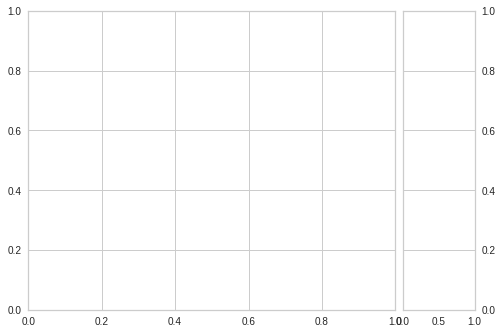

In [69]:
# plot residuals
plot_model(best_lon_model, plot = 'residuals')

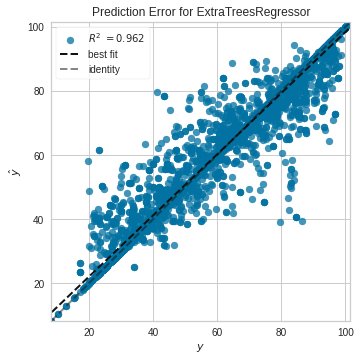

In [49]:
# plot error
plot_model(best, plot = 'error')

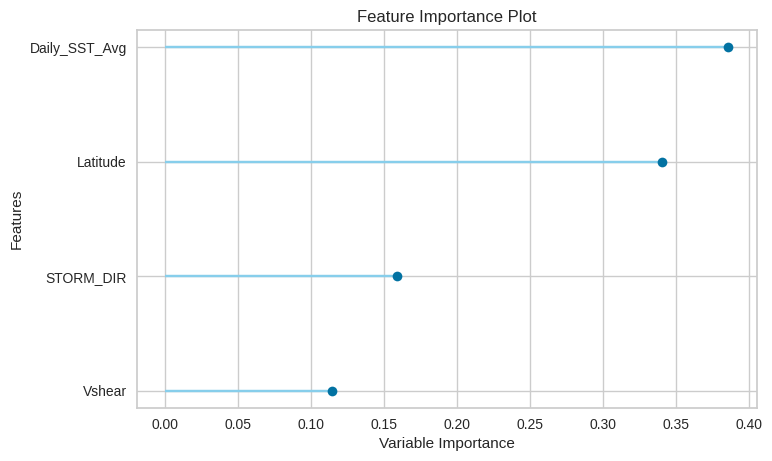

In [50]:
# plot feature importance
plot_model(best, plot = 'feature')

# Building Intensity Model

In [66]:
s_int = setup(df_intensity_data, target = 'Vmax', session_id = 123)

,Description,Value
0,Session id,123
1,Target,Vmax
2,Target type,Regression
3,Original data shape,"(31316, 8)"
4,Transformed data shape,"(31316, 8)"
5,Transformed train set shape,"(21921, 8)"
6,Transformed test set shape,"(9395, 8)"
7,Numeric features,7
8,Preprocess,True
9,Imputation type,simple


In [67]:
# compare baseline models
best_tc_int = compare_models()

Processing:   0%|          | 0/85 [00:00<?, ?it/s]

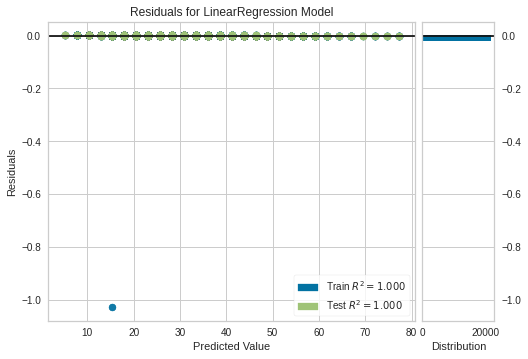

In [59]:
# plot residuals
plot_model(best_tc_int, plot = 'residuals')

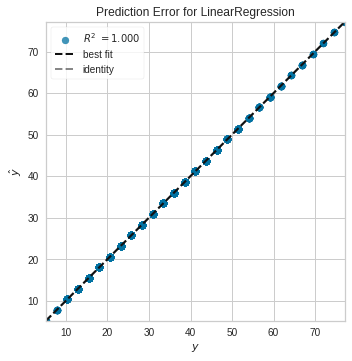

In [60]:
# plot error
plot_model(best_tc_int, plot = 'error')


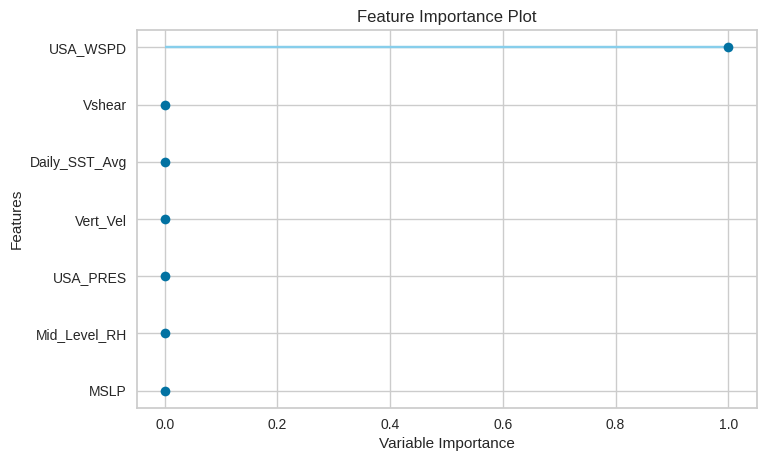

In [61]:
# plot feature importance
plot_model(best_tc_int, plot = 'feature')

In [ ]:
# save pipeline
save_model(best_tc_int, 'tc_intensity_model')
save_model(best_lat_model, 'tc_lat_model')
save_model(best_lon_model, 'tc_lon_model')